In [1]:
# Install SOFA + dependencies
!pip install --quiet biosofa

The input tcga_gyn_data.h5mu needs to be download from zenodo: https://zenodo.org/records/14761127

In [2]:
import sofa
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso,  LinearRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from muon import MuData
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import scanpy as sc
import anndata as ad
from anndata import AnnData
import pickle
import muon
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
import statsmodels
from matplotlib import colors as mp_colors
from muon import MuData
import muon as mu
from decimal import Decimal
from seaborn import axes_style
from mofapy2.run.entry_point import entry_point
import seaborn.objects as so
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable, make_axes_area_auto_adjustable
from matplotlib.ticker import FormatStrFormatter

/home/capraz/hubershare/anaconda3/envs/base_copy/lib/python3.8/site-packages/torch/onnx/_internal/_beartype.py:30: UserWarning: module 'beartype.roar' has no attribute 'BeartypeDecorHintPep585DeprecationWarning'
  warnings.warn(f"{e}")
/home/capraz/hubershare/anaconda3/envs/base_copy/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/capraz/hubershare/anaconda3/envs/base_copy/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be c

# Analysis of TCGA data

## Introduction

In this notebook we will explore how `SOFA` can be used to analyze multi-omics data from the TCGA [[1]](#1). 
Here we give a brief introduction what the SOFA model does and what it can be used for. For a more 
detailed description please refer to our preprint: https://doi.org/10.1101/2024.10.10.617527 


### The SOFA model
Given a set of real-valued data
matrices containing multi-omic measurements from overlapping samples (also called views),
along with sample-level guiding variables that capture additional properties such as batches
or mutational profiles, SOFA extracts an interpretable lower-dimensional data representation,
consisting of a shared factor matrix and modality-specific loading matrices. The goal of these 
factors is to explain the major axes of variation in the data. SOFA explicitly assigns a subset of factors 
to explain both the multi-omics data and the guiding
variables (guided factors), while preserving another subset of factors exclusively
for explaining the multi-omics data (unguided factors). Importantly, this feature allows the
analyst to discern variation that is driven by known sources from novel, unexplained sources
of variability.

#### Interpretation of the factors (Z)
Analogous to the interpretation of factors in PCA, SOFA factors ordinate samples along a
zero-centered axis, where samples with opposing signs exhibit contrasting phenotypes along
the inferred axis of variation, and the absolute value of the factor indicates the strength of the
phenotype. Importantly, SOFA partitions the factors of the low-rank decomposition into
guided and unguided factors: the guided factors are linked to specific guiding variables,
while the unguided factors capture global, yet unexplained, sources of variability in the data. 
The factor values can be used in downstream analysis tasks related to the samples, such as clustering 
or survival analysis. The factor values are called Z in SOFA.

#### Interpretation of the loading weights (W)
SOFA’s loading weights indicate the importance of each feature for its respective factor,
thereby enabling the interpretation of SOFA factors. Loading weights close to zero indicate
that a feature has little to no importance for the respective factor, while large magnitudes
suggest strong relevance. The sign of the loading weight aligns with its corresponding factor,
meaning that positive loading weights indicate higher feature levels in samples with positive
factor values, and negative loading weights indicate higher feature levels in samples with
negative factor values. The top loading weights can be simply inspected or used in downstream analysis such as gene set 
enrichment analysis. The factor values are called W in SOFA.

#### Supported data
SOFA expects a set of matrices containing omics measurements with matching and aligned samples and different features. 
Currently SOFA only supports Gaussian likelihoods, for the multi-omics data. 
Data should therefore be appropriately normalized according to
its omics modality. Additionally, data should be centered and scaled.


For the guiding variables SOFA supports Gaussian, Bernoulli and Categorical likelihoods. Guiding variables
can therefore be continuous, binary or categorical. Guiding variables should be vectors with matching samples with 
the multi-omics data.

In SOFA the multi-omics data is denoted as X and the guiding variables as Y.


### The TCGA data set
The pan-gynecologic cancer multi-omic data set of the cancer genome atlas (TCGA) project[[1]](#1), consists of measurements from the transcriptome (mRNA), proteome, methylome, and miRNA of 2599 samples from five different cancers. Additionally, the study includes data about mutations, metadata, and clinical endpoints progression free interval (PFI) and overall survival (OS). We used SOFA to infer 12 latent factors and guided the first 5 factors with the 5 cancer type labels form gynecologic cancers. We hypothesized that the remaining unguided factors will capture cancer type independent variation.


### References
<a id="1">[1]</a> 
Cancer Genome Atlas Research Network et al. The Cancer Genome Atlas Pan-Cancer analysis project. Nat. Genet. 45, 1113–1120 (2013).

## Read data and set hyperparameters

In [3]:
# First we read the preprocessed data as a single MuData object
mdata = mu.read("data/tcga/tcga_gyn_data.h5mu")
mdata

MuData object with n_obs × n_vars = 2599 × 8926
  obs:	'admin.disease_code', 'Unnamed: 0', 'type', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'clinical_stage', 'histological_type', 'histological_grade', 'initial_pathologic_dx_year', 'menopause_status', 'birth_days_to', 'vital_status', 'tumor_status', 'last_contact_days_to', 'death_days_to', 'cause_of_death', 'new_tumor_event_type', 'new_tumor_event_site', 'new_tumor_event_site_other', 'new_tumor_event_dx_days_to', 'treatment_outcome_first_course', 'margin_status', 'residual_tumor', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction'
  10 modalities
    RNA:	2599 x 4436
      uns:	'llh', 'log1p'
      obsm:	'mask'
    Protein:	2599 x 183
      uns:	'llh'
      obsm:	'mask'
    Methylation:	2599 x 3436
      uns:	'llh', 'log1p'
      obsm:	'mask'
    miRNA:	2599 x 680
      uns:	'llh', 'log1p'
      obsm:	'mask'
    Mutations:	2599 x 186
      uns:	'llh'
      obsm:	'mask'
    brca:	2599 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    cesc:	2599 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    ov:	2599 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    ucec:	2599 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    ucs:	2599 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'

In [4]:
# We create the MuData object Xmdata, which contains the multi-omics data:
Xmdata = MuData({"RNA":mdata["RNA"], "Protein":mdata["Protein"], "Methylation":mdata["Methylation"], "miRNA":mdata["miRNA"]})
# We create the MuData objectYmdata, which contains the guiding variables:
Ymdata = MuData({"BRCA":mdata["brca"], "CESC": mdata["cesc"], "OV": mdata["ov"], "UCEC":mdata["ucec"], "UCS":mdata["ucs"]})

In [5]:
# We set the number of factors to infer
num_factors = 12
# Use obs as metadata of the cell lines
metadata = mdata.obs
# In order to relate factors to guiding variables we need to provide a design matrix (guiding variables x number of factors) 
# indicating which factor is guided by which guiding variable.
# Here we just indicate that the first 5 factors are each guided by a different guiding variable:
design = np.zeros((len(Ymdata.mod), num_factors))
for i in range(len(Ymdata.mod)):
    design[i,i] = 1
    
# convert to torch tensor to make it usable by SOFA
design = torch.tensor(design)
design

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

## Fit the `SOFA` model

In [23]:
model = sofa.SOFA(Xmdata = Xmdata, # the input multi-omics data  
              num_factors=num_factors, # number of factors to infer
              Ymdata = Ymdata, # the input guiding variables
              design = design, # design matrix relating factors to guiding variables
              device='cuda', # set device to "cuda" to enable computation on the GPU, if you don't have a GPU available set it to "cpu"
              seed=42) # set seed to get the same results every time we run it
# train SOFA with learning rate of 0.01 for 3000 steps
model.fit(n_steps=6000, lr=0.01, predict=False)
# decrease learning rate to 0.005 and continue training
model.fit(n_steps=3000, lr=0.005)
models.append(model)
    

Current Elbo 1.40E+07 | Delta: 11086: 100%|██████████| 6000/6000 [13:03<00:00,  7.66it/s]   
Current Elbo 1.39E+07 | Delta: 5385: 100%|██████████| 3000/3000 [12:36<00:00,  3.97it/s]  
Current Elbo 1.39E+07 | Delta: 13180: 100%|██████████| 6000/6000 [25:08<00:00,  3.98it/s]   
Current Elbo 1.38E+07 | Delta: 1659: 100%|██████████| 3000/3000 [12:33<00:00,  3.98it/s] 
Current Elbo 1.39E+07 | Delta: 5138: 100%|██████████| 6000/6000 [25:13<00:00,  3.97it/s]    
Current Elbo 1.38E+07 | Delta: -2798: 100%|██████████| 3000/3000 [12:33<00:00,  3.98it/s]
Current Elbo 1.38E+07 | Delta: 17196: 100%|██████████| 6000/6000 [25:07<00:00,  3.98it/s]   
Current Elbo 1.38E+07 | Delta: -4738: 100%|██████████| 3000/3000 [12:35<00:00,  3.97it/s] 


In [ ]:
# if we would like to save the fitted model we can save it using:
#sofa.tl.save_model(model,"models/model_name")

In [6]:
# load fitted model to exactly reproduce manuscript figures
# to load the model use:
model = sofa.tl.load_model("models/tcga_gyn_model")

## Downstream analysis


### Convergence

We will first assess whether the ELBO loss of SOFA has converged by plotting it over training steps

In [10]:
plt.semilogy(model.history)
plt.xlabel("Training steps")
plt.ylabel("ELBO")

Text(0, 0.5, 'ELBO')

### Variance explained

A good first step in a SOFA analysis is to plot how much variance is explained by each factor for each modality. This gives us an overview 
which factors are active across multiple modalities, capturing correlated variation across multiple measurements 
and which are private to a single modality, most probably capturing technical effects related to this modality.

In [11]:
sofa.pl.plot_variance_explained(model)

<Axes: xlabel='View', ylabel='Factor'>

In [12]:
# We can also plot how much variance of each view is explained
sofa.pl.plot_variance_explained_view(model)

<Axes: xlabel='View', ylabel='R2'>

In [13]:
# or how much variance is explained by each factor in total
sofa.pl.plot_variance_explained_factor(model)

/home/capraz/hubershare/SOFA/sofa/plots/plots.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels,rotation=90)


<Axes: xlabel='View', ylabel='R2'>

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim_matrix = cosine_similarity(model.W[0])
angle_matrix_rad = np.arccos(np.clip(cos_sim_matrix, -1.0, 1.0))  # in radians
angle_matrix_deg = np.abs(np.degrees(angle_matrix_rad) )

In [43]:
flabels = ["Factor 1 (brca)","Factor 2 (cesc)","Factor 3 (ov)","Factor 4 (ucec)","Factor 5 (ucs)"]+[f'Factor {i}' for i in range(6,13)]
matplotlib.rcdefaults() 
plt.rc('axes', axisbelow=True)
font = {
        'size'   : 6}
matplotlib.rc('font', **font)

plt.figure(figsize=(3, 3))
ax = sns.heatmap(
    angle_matrix_deg,
    cmap='RdBu',
    vmin=0, vmax=180,
    center=90,
    annot=False, fmt=".1f",
            xticklabels=[],
            yticklabels=flabels,
    square=True,
    cbar_kws={'label': 'Angle'}
)

# Add a marker at 90° on the colorbar
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 30,60, 90, 120,150, 180])
cbar.set_ticklabels(['0°', '30°','60°', '90°', '120°','150°',  '180°'])
plt.tight_layout()
plt.savefig("factor_angles_tcga.png", dpi=400)

### Check factor guidance

In [14]:
onc = OneHotEncoder()
y = np.array(onc.fit_transform(mdata.obs[["admin.disease_code"]]).todense())
metadata_ = pd.concat((mdata.obs, pd.DataFrame(y, index=mdata.obs.index,columns=onc.categories_[0])), axis=1)
metadata_["patientID"] = metadata_.index


In [15]:
indicator = pd.concat([
    metadata_.loc[:, ['brca']].rename(columns={'brca': 'binary'}).assign(binary=lambda df: df['binary'].astype(float)).assign(Factor=1),
    metadata_.loc[:, ['cesc']].rename(columns={'cesc': 'binary'}).assign(binary=lambda df: df['binary'].astype(float)).assign(Factor=2),
    metadata_.loc[:, ['ov']].rename(columns={'ov': 'binary'}).assign(binary=lambda df: df['binary'].astype(float)).assign(Factor=3),
    metadata_.loc[:, ['ucec']].rename(columns={'ucec': 'binary'}).assign(binary=lambda df: df['binary'].astype(float)).assign(Factor=4),
    metadata_.loc[:, ['ucs']].rename(columns={'ucs': 'binary'}).assign(binary=lambda df: df['binary'].astype(float)).assign(Factor=5),
]
).reset_index()

In [16]:
factor_df = pd.DataFrame(model.Z, index=metadata_.index, columns=[i for i in range(1, 13)])
factor_df["patientID"] = metadata_.index

guided_factor_df = (factor_df
 .reset_index()
 .melt('index', var_name='Factor', value_name='Value') 
 .merge(indicator, on=['index', 'Factor'])

)

(-4.4366262555122375, 4.0)

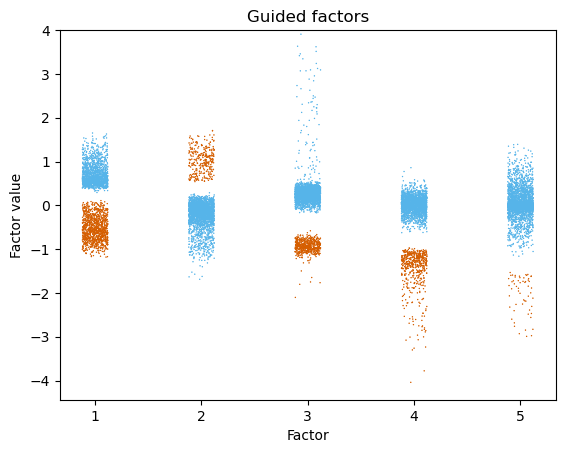

In [17]:
fig, ax = plt.subplots()
p1 = (
    so.Plot(guided_factor_df, x='Factor', y='Value', color='binary')
    .add(so.Dot(pointsize=0.5),  so.Jitter(.3), legend=False)
    .scale(color=['#56b4e9', '#d55e00'])
    .theme(axes_style("white"))
    # .layout(engine="constrained")
)
# used to be B
p1.on(ax).plot() #.show()
ax.set_title('Guided factors')
ax.set_ylabel('Factor value')
ax.set_ylim(top=4)


### Downstream analysis of the factor values

The factor values represent the new coordinates in lower dimensional space of our samples and have dimensions samples x factors. 
The factor values called Z in SOFA.
We can use the factor values for all kinds of downstream analyses on the sample level. Here we will cluster the unguided factors.

We first retrieve the factor values:

In [18]:
Z = sofa.tl.get_factors(model)
Z

Factor_1 (brca)  Factor_2 (cesc)  Factor_3 (ov)  \
TCGA-A1-A0SB        -0.068559        -0.956759       0.395876   
TCGA-A1-A0SD        -0.791113        -0.176194       0.162773   
TCGA-A1-A0SE        -0.649877        -0.516037       0.241078   
TCGA-A1-A0SF        -0.436990        -0.397665       0.262103   
TCGA-A1-A0SG        -0.796272        -0.228161       0.087272   
...                       ...              ...            ...   
TCGA-NF-A5CP         0.384871         0.149592       0.140378   
TCGA-NG-A4VU         0.511174        -0.193516       0.299988   
TCGA-NG-A4VW         0.668518         0.125276       0.162740   
TCGA-QM-A5NM         1.058689         0.071231       0.241933   
TCGA-QN-A5NN         0.386474        -0.215088       0.212471   

              Factor_4 (ucec)  Factor_5 (ucs)  Factor_6  Factor_7  Factor_8  \
TCGA-A1-A0SB         0.353804       -0.449537 -0.244394 -0.489684  0.234003   
TCGA-A1-A0SD         0.077882        0.022851  0.090326  0.110678  0.036941   
TCGA-A1-A0SE         0.019738        0.355230  0.079890 -0.057455  0.151067   
TCGA-A1-A0SF        -0.131475        0.457887  0.311861  0.133225  0.461349   
TCGA-A1-A0SG        -0.005371        0.616239  0.122077  0.041294  0.088474   
...                       ...             ...       ...       ...       ...   
TCGA-NF-A5CP         0.200661       -1.616578  0.166475  0.342098 -0.267612   
TCGA-NG-A4VU         0.069122       -2.975001 -1.160977  0.002463  0.582547   
TCGA-NG-A4VW         0.090213       -1.621962  0.385436 -0.587095  0.180678   
TCGA-QM-A5NM        -0.284919       -1.533058  0.279359 -0.279391  0.174577   
TCGA-QN-A5NN        -0.068811       -1.736867 -0.674749  0.190650 -0.281425   

              Factor_9  Factor_10  Factor_11  Factor_12  
TCGA-A1-A0SB  0.364860  -0.349728  -0.021216   0.583005  
TCGA-A1-A0SD  0.281851  -0.163649  -0.056130   0.102763  
TCGA-A1-A0SE  0.365583  -0.202970  -0.646631   0.212070  
TCGA-A1-A0SF  0.154909  -0.215308   0.080673   0.108758  
TCGA-A1-A0SG  0.196174  -0.137173  -0.251898  -0.354120  
...                ...        ...        ...        ...  
TCGA-NF-A5CP  0.145394   0.229709   0.012862  -0.198812  
TCGA-NG-A4VU  0.403265   0.781878  -0.013149  -0.131417  
TCGA-NG-A4VW  0.314375   0.189267  -0.081897   0.192156  
TCGA-QM-A5NM  0.358607   0.190392   0.053573  -0.531947  
TCGA-QN-A5NN  0.337099   0.273190   0.074353  -0.624181  

[2599 rows x 12 columns]

We will plot a tSNE of all the factors and color them by cancer type and by Factor 10:

In [19]:
tsne = TSNE()
tsne_z = tsne.fit_transform(model.Z[:,5:])
tsne_z_all = tsne.fit_transform(model.Z)
metadata =mdata.obs

In [20]:
fig,ax = plt.subplots(ncols=2)

include = metadata["admin.disease_code"].astype(str) != "nan"
tsne_z_ = tsne_z_all[include,:]
cancer_types = metadata["admin.disease_code"].loc[include]

for ix, i in enumerate(np.unique(cancer_types.astype(str))):
    ax[0].scatter(tsne_z_[cancer_types==i,0],tsne_z_[cancer_types==i,1],s = 1,alpha=0.6, c=sns.color_palette("colorblind", as_cmap=True)[ix], label=i)
ax[0].set_aspect("equal")
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_xlabel("tSNE 1")
ax[0].set_ylabel("tSNE 2")
ax[0].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, 
    left=False,# ticks along the top edge are off
    labelbottom=False,
labelleft=False,) # labels along the bottom edge are off


divnorm=mp_colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
plot = ax[1].scatter(tsne_z_all[:,0],tsne_z_all[:,1],s = 1,alpha=1, c=model.Z[:,9],cmap="RdBu", norm=divnorm)
ax[1].set_aspect("equal")
#plt.colorbar(plot) 
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax, label="Factor 10") 
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xlabel("tSNE 1")
ax[1].set_ylabel("tSNE 2")
ax[1].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, 
    left=False,# ticks along the top edge are off
    labelbottom=False,
labelleft=False,) # labels along the bottom edge are off



We will plot a tSNE of only the unguided factors and color them by cancer type and by Factor 10:

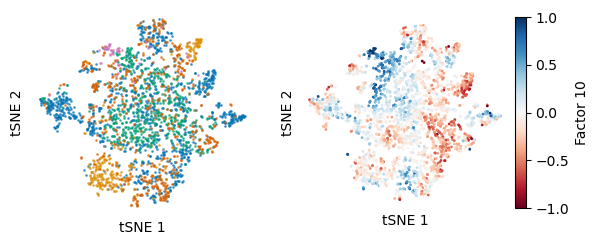

In [21]:
fig,ax = plt.subplots(ncols=2)

include = metadata["admin.disease_code"].astype(str) != "nan"
tsne_z_ = tsne_z[include,:]
cancer_types = metadata["admin.disease_code"].loc[include]

for ix, i in enumerate(np.unique(cancer_types.astype(str))):
    ax[0].scatter(tsne_z_[cancer_types==i,0],tsne_z_[cancer_types==i,1],s = 1,alpha=0.6, c=sns.color_palette("colorblind", as_cmap=True)[ix], label=i)
ax[0].set_aspect("equal")
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_xlabel("tSNE 1")
ax[0].set_ylabel("tSNE 2")
ax[0].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, 
    left=False,# ticks along the top edge are off
    labelbottom=False,
labelleft=False,) # labels along the bottom edge are off


divnorm=mp_colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
plot = ax[1].scatter(tsne_z_[:,0],tsne_z_[:,1],s = 1,alpha=1, c=model.Z[:,9],cmap="RdBu", norm=divnorm)
ax[1].set_aspect("equal")
#plt.colorbar(plot) 
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax, label="Factor 10") 
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xlabel("tSNE 1")
ax[1].set_ylabel("tSNE 2")
ax[1].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, 
    left=False,# ticks along the top edge are off
    labelbottom=False,
labelleft=False,) # labels along the bottom edge are off


As we can see from the tSNE of only the unguided factors, the cancer type information is regressed from the latent space. 
To quantify the how much of the cancer label information was regressed out. We performed multiple SOFA runs guided by cancer labels and fully unguided "null" models. 
Then calculated the ARI for the cancer type labels on either all, only the unguided factors or the fully unguided latent space.

/tmp/ipykernel_1014/412390681.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Adjusted Rand Index')

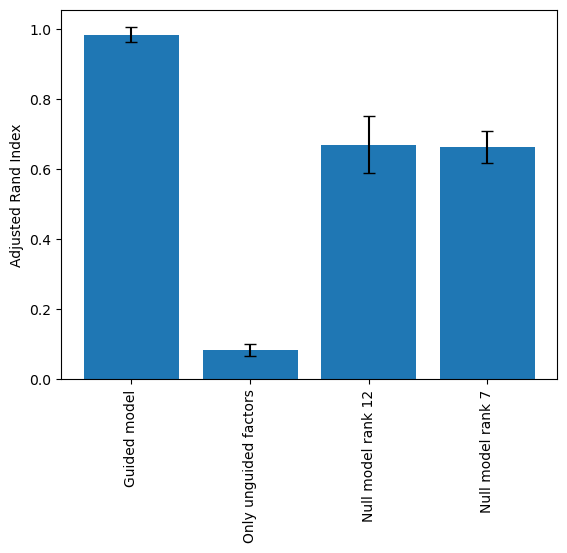

In [22]:
stats = pd.read_csv("data/tcga/pan_gyn_integrations_stats.csv", index_col=0)
stats = stats.dropna(axis=1)
stats = stats[np.sort(stats.columns)]
ari = stats.iloc[:,0:4]
ari.columns =["Guided model", "Only unguided factors", "Null model rank 12", "Null model rank 7"]

fig,ax = plt.subplots()
ax.bar(ari.columns, height=np.mean(ari,axis=0),yerr=np.std(ari,axis=0),capsize=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Adjusted Rand Index")

#### Survival analysis with SOFA factors

Here we test whether the inferred SOFA factors are associated with overall survival (OS) or progression free survival (PFI).
We use univariate Cox regression for each factor individually. 

In [23]:
# get overall survival data
OS  = mdata.obs[["OS", "OS.time"]].astype(float)
# get progression free interval data
PFI  = mdata.obs[["PFI", "PFI.time"]].astype(float)

In [24]:
Z_pred = model.Z.copy()
# flip sign of factor 3 and 5
Z_pred[:,2] = Z_pred[:,2]*-1
Z_pred[:,4] = Z_pred[:,4]*-1

# output df
OS_cox = pd.DataFrame(columns=["factor", "hazard_ratios","lower", "upper", "pvalues"], index=range(Z_pred.shape[1]))

for i in range(Z_pred.shape[1]):

    cph = CoxPHFitter()

    cox_data = OS
    factor = pd.Series(Z_pred[:,i], index=cox_data.index)
    
    d= pd.concat((cox_data, factor), axis=1)

    d= d[~d.isna().any(axis=1)]
    cph.fit(d, duration_col = 'OS.time', event_col = "OS")
    OS_cox.loc[i,"pvalues"] = cph.summary["p"][0]
    OS_cox.loc[i,"hazard_ratios"] = cph.summary["exp(coef)"][0]
    OS_cox.loc[i,"lower"] = cph.summary["exp(coef) lower 95%"][0]
    OS_cox.loc[i,"upper"] = cph.summary["exp(coef) upper 95%"][0]
    OS_cox.loc[i,"factor"] = "Factor "+str(i+1)

Here we visualize the fitted coefficients (hazard ratios) and p-values to identify which factors are associated with survival.

In [25]:
# plot forest plot with hazard ratios and confidence interval 
import statsmodels.api as sm
fig,ax = plt.subplots()
ci = pd.concat((OS_cox["hazard_ratios"]-OS_cox["lower"], OS_cox["upper"]-OS_cox["hazard_ratios"]), axis=1).T
OS_cox["padj"] = statsmodels.stats.multitest.multipletests(OS_cox["pvalues"].astype(float))[1]
pvals = ["P=" + np.format_float_scientific(i,precision=2)for i in OS_cox["padj"].values]
sig = OS_cox["padj"].values < 0.01
nonsig = OS_cox["padj"].values >=0.01
ax.errorbar(y=OS_cox["hazard_ratios"][nonsig], x=OS_cox.index.values[nonsig]+0.5, yerr=ci.values[:,nonsig],
            color='black',  capsize=5, linestyle='None', linewidth=1,
            marker="o",  mfc="black", mec="black", label="adj. p-value > 0.01")
ax.errorbar(y=OS_cox["hazard_ratios"][sig], x=OS_cox.index.values[sig]+0.5, yerr=ci.values[:,sig],
            color='black',  capsize=5, linestyle='None', linewidth=1,
            marker="o",  mfc="#ff7f0e", mec="#ff7f0e", label="adj. p-value < 0.01")
ax.axhline(y=1, linewidth=0.8, linestyle='--', color='black')
ax.tick_params(axis='x', which='minor',bottom=False)
ax.set_ylabel('Hazard ratios \n(95% CI)')
ax.set_xticks(ticks= np.arange(12)+0.5, labels=["Factor" +str(i) for i in range(1,13)], rotation=90)

nonsig_patch = mpatches.Patch(color='black', label="adj. p-value > 0.01")
sig_patch = mpatches.Patch(color='#ff7f0e', label="adj. p-value < 0.01")

ax.legend(handles=[nonsig_patch, sig_patch], frameon=False, ncols=2)

Factor 10 is significantly associated with overall survival. We can further investigate its association to OS by plotting Kaplan-Meier curves:

In [26]:

mask = ~OS.isna().any(axis=1)
OS = OS.dropna()
PFI = PFI.dropna()
f10 = Z_pred[mask,9]

In [27]:
# plot Kaplan Meier curve for factor 10 and PFI

low,high = np.percentile(f10, [50,95])

fig,ax = plt.subplots()
kmf = KaplanMeierFitter()
results = logrank_test(PFI['PFI.time'][f10>high], PFI['PFI.time'][f10<low].dropna(), PFI['PFI'][f10>high], event_observed_B=PFI['PFI'][f10<low].dropna())
kmf.fit(PFI['PFI.time'][f10>high], PFI['PFI'][f10>high], label="Factor 10 high")
kmf.plot(ax=ax,ci_show=False)
kmf = KaplanMeierFitter()
kmf.fit(PFI['PFI.time'][f10<low].dropna(), PFI['PFI'][f10<low].dropna(), label="Factor 10 low")
kmf.plot(ax=ax,ci_show=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_tick_params(labelleft=True)
ax.set_xlabel("Progression free interval \n(days)")
ax.set_ylabel("Survival probability (%)")
ax.text(1100, 0.9,  "p-value = "+"%1.1E" % Decimal(str(results.p_value)))
ax.legend(frameon=False)

/home/capraz/hubershare/anaconda3/envs/base_copy/lib/python3.8/site-packages/lifelines/plotting.py:919: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  dataframe_slicer(plot_estimate_config.estimate_).rename(columns=lambda _: plot_estimate_config.kwargs.pop("label")).plot(
/home/capraz/hubershare/anaconda3/envs/base_copy/lib/python3.8/site-packages/lifelines/plotting.py:919: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  dataframe_slicer(plot_estimate_config.estimate_).rename(columns=lambda _: plot_estimate_config.kwargs.pop("label")).plot(


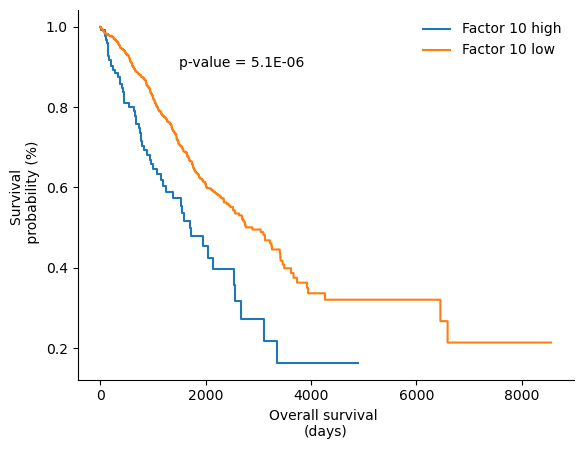

In [28]:
# plot Kaplan Meier curve for factor 10 and OS

fig,ax = plt.subplots()
results = logrank_test(OS['OS.time'][f10>high], OS['OS.time'][f10<low].dropna(), OS['OS'][f10>high], event_observed_B=OS['OS'][f10<low].dropna())
kmf = KaplanMeierFitter()

kmf.fit(OS['OS.time'][f10>high].dropna(), OS['OS'][f10>high].dropna(), label="Factor 10 high")
kmf.plot(ax=ax, ci_show=False)
kmf = KaplanMeierFitter()
kmf.fit(OS['OS.time'][f10<low].dropna(), OS['OS'][f10<low].dropna(), label="Factor 10 low")
kmf.plot(ax=ax, ci_show=False, cmap="colorblind")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Overall survival \n(days)")
ax.text(1500, 0.9,  "p-value = "+"%1.1E" % Decimal(str(results.p_value)))

ax.set_ylabel("Survival \n probability (%)", visible=True)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax.legend(frameon=False)

### Downstream analysis of loading weights

The loadings capture the importance of the features in each omics modality for each factor, they have dimensions: factors x features. To retrieve the loadings run:

In [29]:
# specify the view of which we want to retrieve the loadings
W = sofa.tl.get_loadings(model, view="rna")
W

IGF2      DLK1   CYP17A1      APOE      SLPI   CYP11B1  \
Factor_1 (brca)  0.256977  0.464854  0.425984  0.109858  1.112575  0.103872   
Factor_2 (cesc) -0.371340 -0.627032 -0.278327 -0.231412 -0.320379  0.021412   
Factor_3 (ov)   -0.558795 -0.102920 -1.380738 -0.295772 -0.245436  0.169791   
Factor_4 (ucec)  0.321659  0.274981  0.148637 -0.832970  0.020647  0.033767   
Factor_5 (ucs)  -0.246544 -0.396687 -0.053422 -0.028221  0.059327 -0.059312   
Factor_6         0.056331 -0.018716  0.026955 -0.245057  0.252097 -0.084610   
Factor_7         0.944083  0.190422 -0.057485  1.765003  0.045593  0.235488   
Factor_8         0.567729  0.866502  0.309059  0.263794 -0.752690  0.049291   
Factor_9         1.361504  0.462694  0.173420 -0.463739 -0.196467 -0.239038   
Factor_10        0.280253  0.628980  0.000314  0.263023 -0.880207 -0.004985   
Factor_11       -0.017417 -0.049315  0.036915  0.014929 -0.023290  0.029108   
Factor_12       -0.046363 -0.025982 -0.078152 -0.990845  0.123614 -0.020091   

                     STAR       H19      GNAS     GAPDH  ...   LRRN4CL  \
Factor_1 (brca)  0.529434  0.286809  0.498709  1.013466  ...  0.367414   
Factor_2 (cesc) -0.323378 -0.197620 -0.858876 -0.654136  ... -0.292036   
Factor_3 (ov)   -0.371026 -0.326948  0.071627 -0.148008  ... -0.026116   
Factor_4 (ucec) -0.202398  0.065250 -1.134238 -1.619760  ...  0.295630   
Factor_5 (ucs)   0.274254 -0.084729 -0.194032 -0.108764  ...  0.092816   
Factor_6        -0.308168  0.120581  0.316507 -0.160259  ...  0.106847   
Factor_7        -0.119139  0.720282  0.056930 -0.210789  ...  1.772369   
Factor_8         0.931249 -0.032493 -0.359230 -0.975684  ...  0.737753   
Factor_9        -0.203452  0.735064  0.491511 -0.076739  ...  1.247741   
Factor_10        0.116316 -0.213680  0.927243  0.325137  ... -0.442285   
Factor_11       -0.020272 -0.001592  0.028506 -0.010991  ... -0.017803   
Factor_12        0.017208 -0.359655 -0.125432 -0.198495  ...  0.023031   

                  SLC25A1    ARID5B      RHOQ     PDE6G  KIAA0664   FAM134A  \
Factor_1 (brca)  0.587168  0.027022  0.064519  0.255864  0.737403 -0.468108   
Factor_2 (cesc) -0.237705 -0.305694 -0.874484 -0.383729 -0.336187 -0.245804   
Factor_3 (ov)   -0.034537 -0.406462 -0.257028 -0.613797 -0.093484 -0.939213   
Factor_4 (ucec) -1.465490  1.537956  0.259835 -0.707334  0.781751 -0.384141   
Factor_5 (ucs)   0.252733  0.035070 -0.412078 -0.065257  0.324985  0.109216   
Factor_6         0.229631  0.029902  0.188749 -0.011532 -0.216373  0.151458   
Factor_7         0.157764  0.819517  0.625311  1.294285 -0.240169 -0.199078   
Factor_8        -0.696783  0.189181 -0.056764  0.683843 -0.067248  0.573768   
Factor_9         0.358347  0.286029  0.187339 -0.728862 -0.415017  0.249448   
Factor_10        0.154566 -0.581967  0.341046  0.377159 -0.124212 -0.156052   
Factor_11       -0.123792  0.022235 -0.062988  0.032762 -0.021049 -0.052274   
Factor_12       -0.938130  0.821455  0.410206 -0.300631 -0.820548 -0.382904   

                     PEX6      NARF     TRAF7  
Factor_1 (brca)  0.264154  0.999687  0.338431  
Factor_2 (cesc) -0.461135 -0.451547 -0.009286  
Factor_3 (ov)   -0.158356  0.479365 -0.332378  
Factor_4 (ucec) -0.071286 -0.721724  0.367421  
Factor_5 (ucs)  -0.071969  0.008588  0.196552  
Factor_6        -0.031476  0.122704 -0.108069  
Factor_7        -0.321732  0.018755 -0.211537  
Factor_8         0.351589 -0.339139 -0.256080  
Factor_9         0.128513 -0.140165  0.117316  
Factor_10       -0.333031  0.964307  0.109611  
Factor_11        0.012072  0.063581 -0.015236  
Factor_12       -0.754267 -0.709637 -0.756123  

[12 rows x 4436 columns]

In [30]:
# Plot top loadings for factor 1 (breast cancer)
sofa.pl.plot_top_loadings(model, view="protein", factor = 1, top_n=10)

<Axes: xlabel='Loadings', ylabel='Features'>

In [31]:
# Plot top loadings for factor 3 (breast cancer)
sofa.pl.plot_top_loadings(model, view="rna", factor = 3, top_n=20)

<Axes: xlabel='Loadings', ylabel='Features'>

<Axes: xlabel='Loadings', ylabel='Features'>

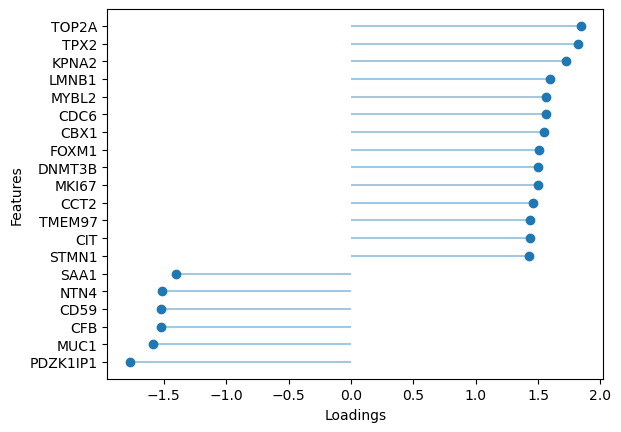

In [32]:
# Plot top rna loadings for factor 10 
sofa.pl.plot_top_loadings(model, view="rna", factor = 10, top_n=20)

<Axes: xlabel='Loadings', ylabel='Features'>

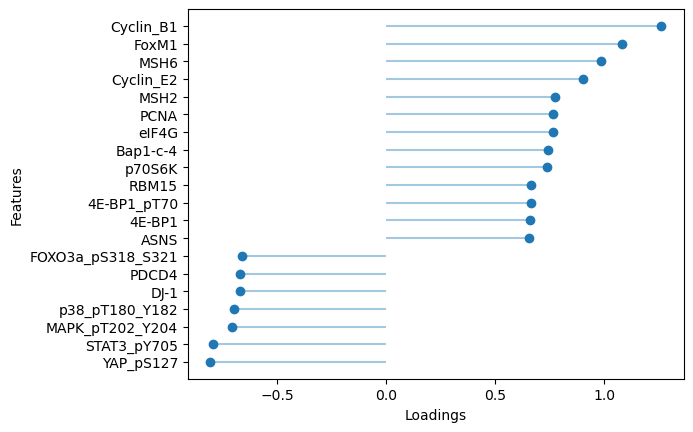

In [33]:
# Plot top protein loadings for factor 10 
sofa.pl.plot_top_loadings(model, view="protein", factor = 10, top_n=20)

<Axes: xlabel='-log10 adjusted p-values', ylabel='Gene sets'>

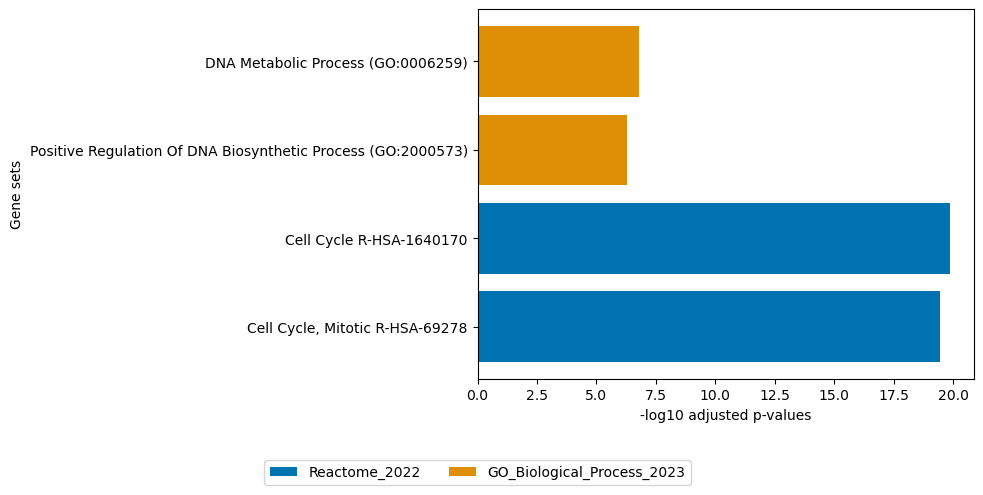

In [35]:
# plot enrichment of loadings of factor 10
loadings = sofa.tl.get_top_loadings(model,factor=10, view="rna", sign="+", top_n=100)
loadings2 = sofa.tl.get_top_loadings(model,factor=10, view="rna", sign="-", top_n=100)

sofa.pl.plot_enrichment(loadings, background=mdata.mod["RNA"].var, db=[ "Reactome_2022","GO_Biological_Process_2023"], top_n=[2,2])
sofa.pl.plot_enrichment(gene_list=loadings2,db=["Reactome_2022"], top_n=[4],background=mdata.mod["RNA"].var)

